In [1]:
%cd /home/yokoyama/ahar
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

sys.path.append(".")
from modules.individual import IndividualActivityRecognition, IndividualDataFormat, IndividualDataHandler
from modules.utils.constants import Stages

/raid6/home/yokoyama/ahar


In [2]:
# set constants
model_type = "ganomaly"
train_data_dir = os.path.join("data", "dataset01", "train")
test_data_dir = os.path.join("data", "dataset01", "test")
data_types = ["bbox", "local"]
seq_len = 150
masking = True

In [3]:
# load results
def load_results(data_dir, model_type, data_type, masking, seq_len, data_keys):
    results = {}
    for data_dir in tqdm(sorted(glob(os.path.join(data_dir, "*")))):
        video_num = os.path.basename(data_dir)
        results[video_num] = IndividualDataHandler.load(data_dir, model_type, data_type, masking, seq_len, data_keys)

    return results

In [4]:
data_keys = [IndividualDataFormat.kps_real, IndividualDataFormat.kps_fake]
train_results = {}
test_results = {}
for data_type in data_types:
    train_results[data_type] = load_results(train_data_dir, model_type, data_type, masking, seq_len, data_keys)
    test_results[data_type] = load_results(test_data_dir, model_type, data_type, masking, seq_len, data_keys)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
def get_results_ind(results):
    results_ind = {}
    for video_num, video_results in tqdm(results.items()):
        ind_results = {}
        for item in video_results:
            pid = item[IndividualDataFormat.id]
            if pid not in ind_results:
                # initialize individual data
                ind_results[pid] = {
                    key: [] for key in IndividualDataFormat.get_attributes()
                    if key != IndividualDataFormat.id
                }

            # append individual data
            for key, value in item.items():
                if key != IndividualDataFormat.id:
                    ind_results[pid][key].append(item[key])
        results_ind[video_num] = ind_results
    return results_ind

In [10]:
train_results_ind = {}
test_results_ind = {}
for data_type in data_types:
    results = get_results_ind(train_results[data_type])
    # change data structure
    for video_num, vals in results.items():
        if video_num not in train_results_ind:
            train_results_ind[video_num] = {}
        train_results_ind[video_num][data_type] = vals

    results = get_results_ind(test_results[data_type])
    # change data structure
    for video_num, vals in results.items():
        if video_num not in test_results_ind:
            test_results_ind[video_num] = {}
        test_results_ind[video_num][data_type] = vals

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
graph = [
    # ========== 4 ============ 9 =========== 14 =====
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Nose
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEye
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REye
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEar
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REar
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # LShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  # RShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # LElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # RElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # LHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # RHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # LKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # RKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LAnkle
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RAnkle
]

def plot_keypoints(img, kps, color):
    for i in range(len(kps) - 1):
        for j in range(i + 1, len(kps)):
            if graph[i][j] == 1:
                p1 = tuple(kps[i].astype(int))
                p2 = tuple(kps[j].astype(int))
                img = cv2.line(img, p1, p2, color, 3)
    return img

In [12]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 16
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in


def plot(results, video_num, pid, frame_num, stage, seq_len=10, n_col=10, ratio=(300, 400)):
    fig = plt.figure(figsize=(26, 7))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0)

    video_results = results[video_num]
    for i, (data_type, ind_results) in enumerate(video_results.items()):
        ind_result = ind_results[pid]
        frame_nums = ind_result[IndividualDataFormat.frame_num]
        print(frame_nums)
        idx = frame_nums.index(frame_num)
        kps_real = ind_result[IndividualDataFormat.kps_real][idx]
        kps_fake = ind_result[IndividualDataFormat.kps_fake][idx]

        step = len(kps_real) // seq_len
        kps_real = kps_real[step - 1::step]
        kps_fake = kps_fake[step - 1::step]

        mins = np.min(
            np.append(np.min(kps_real, axis=1), np.min(kps_fake, axis=1), axis=0),
            axis=0
        )
        maxs = np.max(
            np.append(np.max(kps_real, axis=1), np.max(kps_fake, axis=1), axis=0),
            axis=0
        )
        size = ((maxs - mins) * ratio).astype(int)
        kps_real = (kps_real - mins) * ratio
        kps_fake = (kps_fake - mins) * ratio
        print(mins, maxs)
        print(size)

        for j in range(seq_len):
            img = np.full((size[1], size[0], 3), 255, np.uint8)
            if img.shape[0] > 0 and img.shape[1] > 0:
                img = plot_keypoints(img, kps_real[j], (0, 255, 0))  # real: green
                img = plot_keypoints(img, kps_fake[j], (255, 0, 0))  # fake: red
                ax = fig.add_subplot(2, seq_len, i * seq_len + j + 1)
                ax.imshow(img)
                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)

        # save fig
        # path = os.path.join(
        #     "data", "images", "individual", model_type, data_name, f"{stage}", f"{video_num}.jpg"
        # )
        # os.makedirs(os.path.dirname(path), exist_ok=True)
        # plt.savefig(path, bbox_inches='tight')

    # show
    plt.show()

[150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,

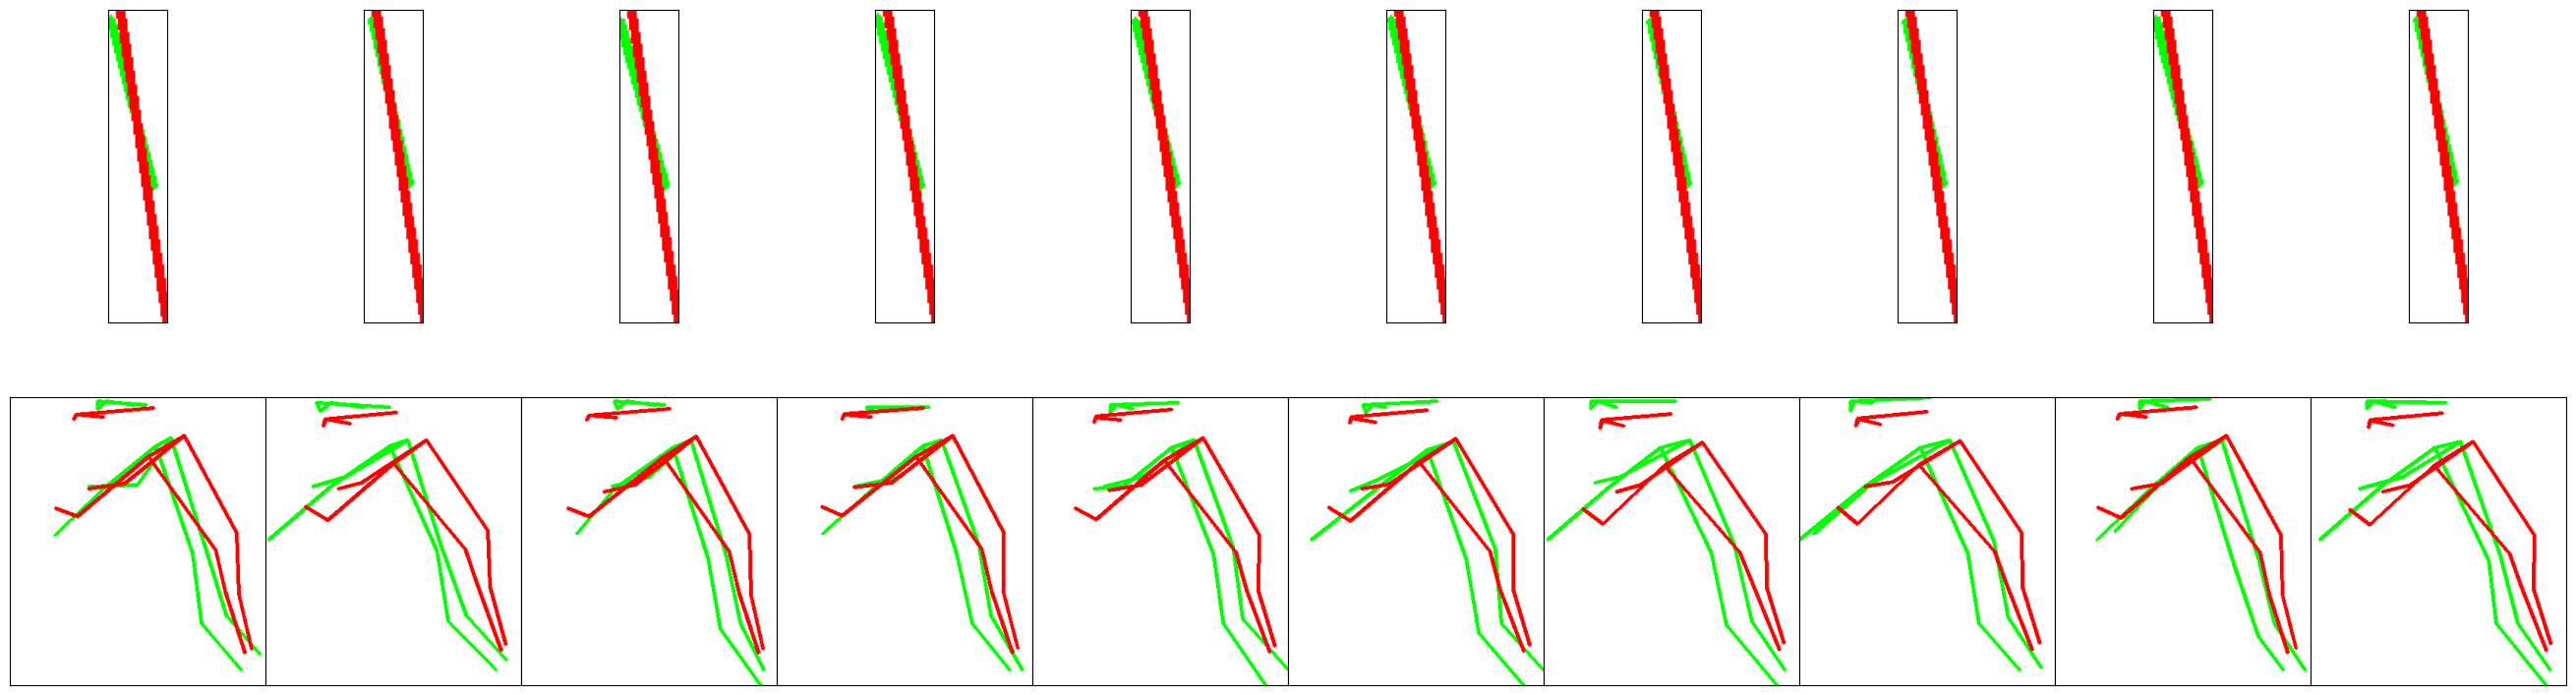

In [18]:
plot(train_results_ind, video_num="01", pid="2", frame_num=150, stage="train")

[256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1

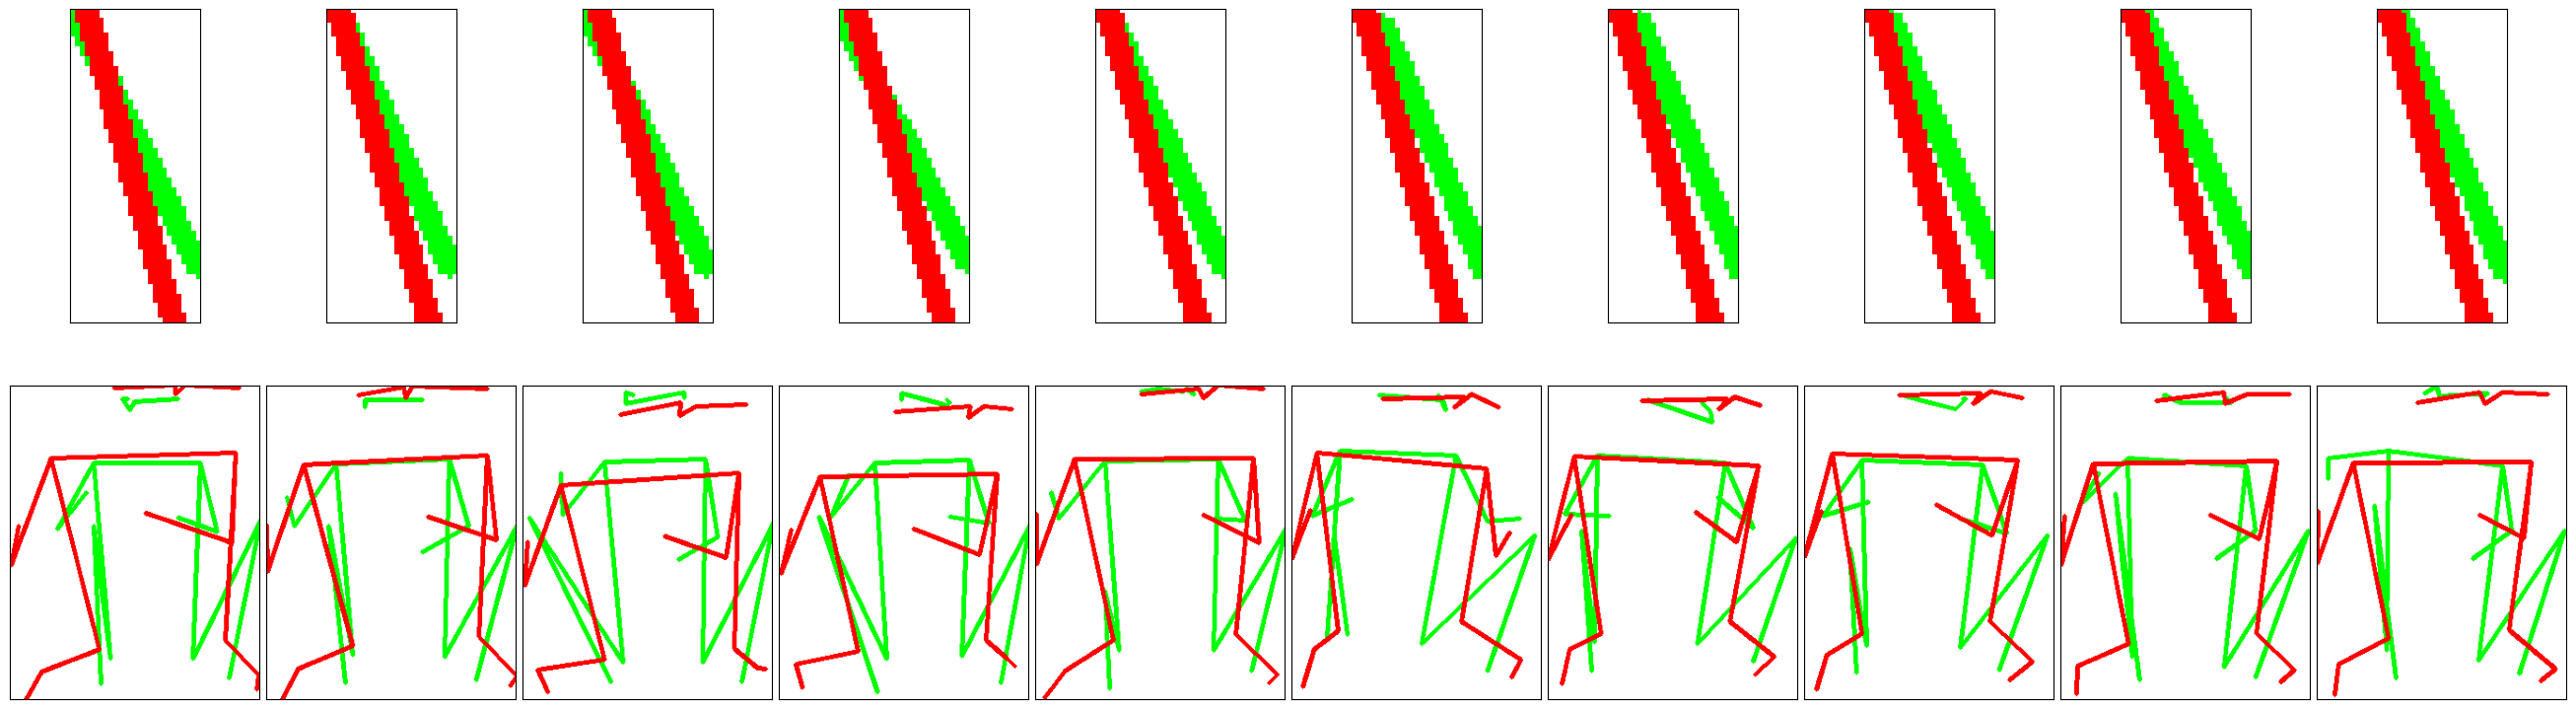

In [17]:
plot(test_results_ind, video_num="03", pid="56", frame_num=2218, stage="test")